<a href="https://colab.research.google.com/github/induxtrias/365-days-value-prediction/blob/main/365_days_value_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ingrese el ticker del stock (e.g., AAPL): PH


[*********************100%***********************]  1 of 1 completed


Gradient Boosting - Train MSE: 44.40259118050092
Gradient Boosting - Test MSE: 54.00970115219744
Gradient Boosting - R^2: 0.9959541227843433
Gradient Boosting - Predicted price for 2025-09-26: $618.20
Gradient Boosting - 95% Confidence Interval: ($603.80, $632.60)
Bayesian Ridge - Train MSE: 2526.903645570687
Bayesian Ridge - Test MSE: 2572.1518069297094
Bayesian Ridge - R^2: 0.8073196079803944
Bayesian Ridge - Predicted price for 2025-09-26: $547.70
Bayesian Ridge - 95% Confidence Interval: ($448.30, $647.10)
Linear Regression - Train MSE: 2526.903220924213
Linear Regression - Test MSE: 2572.1654748763326
Linear Regression - R^2: 0.8073185841118551
Linear Regression - Predicted price for 2025-09-26: $547.75
Linear Regression - 95% Confidence Interval: ($448.35, $647.15)
Decision Tree - Train MSE: 0.0
Decision Tree - Test MSE: 34.918696773333544
Decision Tree - R^2: 0.9973842336346661
Decision Tree - Predicted price for 2025-09-26: $621.82
Decision Tree - 95% Confidence Interval: ($610

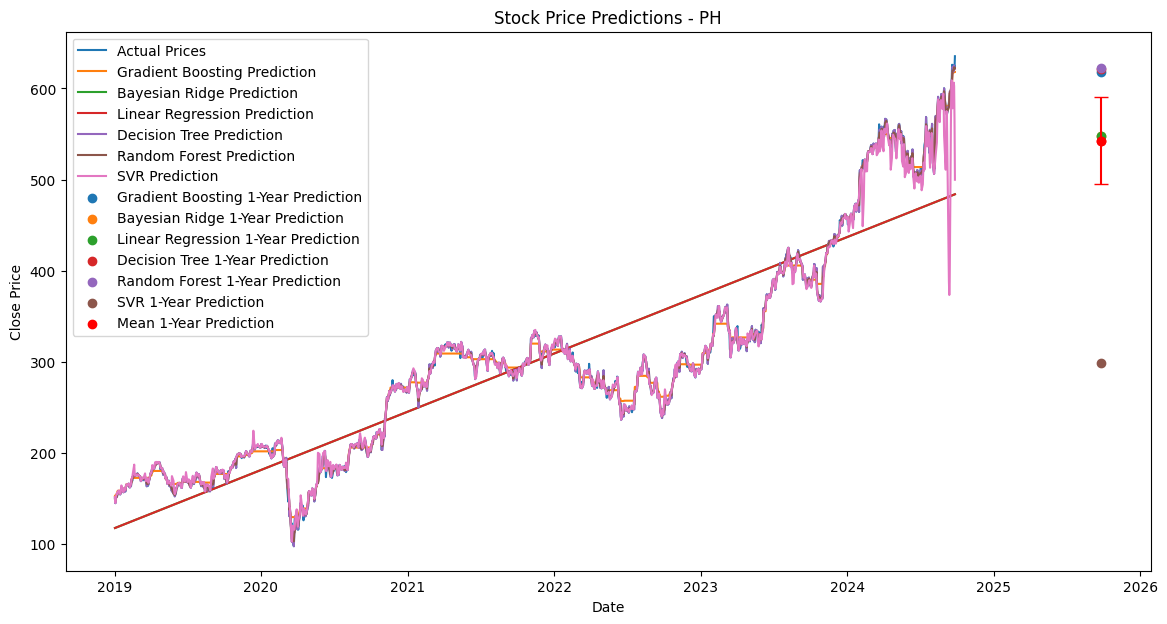

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import norm
import matplotlib.pyplot as plt
import datetime

# Solicitar al usuario el ticker del stock
ticker = input("Ingrese el ticker del stock (e.g., AAPL): ").upper()

# Descargar datos históricos del stock especificado
data = yf.download(ticker, start='2019-01-01', end='2024-09-27')

# Verificar si se descargaron datos
if data.empty:
    print(f"No se pudieron obtener datos para el ticker '{ticker}'. Verifique el ticker y vuelva a intentarlo.")
else:
    # Preprocesamiento de los datos
    data['Date'] = data.index
    data['Date'] = pd.to_datetime(data['Date'])
    data['Date_ordinal'] = data['Date'].apply(lambda x: x.toordinal())

    # Seleccionar características (Date_ordinal) y la variable objetivo (Close)
    X = data[['Date_ordinal']].values
    y = data['Close'].values

    # Dividir en conjunto de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Crear y entrenar los modelos
    models = {
        "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
        "Bayesian Ridge": BayesianRidge(),
        "Linear Regression": LinearRegression(),
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "SVR": SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
    }

    # Diccionario para almacenar las predicciones futuras de cada modelo
    future_predictions = {}
    confidence_intervals = {}

    # Entrenar y evaluar los modelos
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        train_mse = mean_squared_error(y_train, y_pred_train)
        test_mse = mean_squared_error(y_test, y_pred_test)
        r2 = r2_score(y_test, y_pred_test)

        print(f'{name} - Train MSE: {train_mse}')
        print(f'{name} - Test MSE: {test_mse}')
        print(f'{name} - R^2: {r2}')

        # Realizar predicción para un año en el futuro
        future_date = data['Date'].max() + datetime.timedelta(days=365)
        future_date_ordinal = np.array([[future_date.toordinal()]])
        future_prediction = model.predict(future_date_ordinal)
        future_predictions[name] = future_prediction[0]
        print(f'{name} - Predicted price for {future_date.strftime("%Y-%m-%d")}: ${future_prediction[0]:.2f}')

        # Calcular el intervalo de confianza para la predicción
        # Usando el error estándar de la predicción y una distribución normal
        se = np.sqrt(test_mse)
        z_score = norm.ppf(0.975)  # para un intervalo de confianza del 95%
        ci_lower = future_prediction[0] - z_score * se
        ci_upper = future_prediction[0] + z_score * se
        confidence_intervals[name] = (ci_lower, ci_upper)
        print(f'{name} - 95% Confidence Interval: (${ci_lower:.2f}, ${ci_upper:.2f})')

    # Calcular la media de las predicciones y sus intervalos de confianza
    mean_prediction = np.mean(list(future_predictions.values()))
    mean_ci_lower = np.mean([ci[0] for ci in confidence_intervals.values()])
    mean_ci_upper = np.mean([ci[1] for ci in confidence_intervals.values()])

    print(f'Mean predicted price for {future_date.strftime("%Y-%m-%d")}: ${mean_prediction:.2f}')
    print(f'Mean 95% Confidence Interval: (${mean_ci_lower:.2f}, ${mean_ci_upper:.2f})')

    # Visualizar los resultados
    plt.figure(figsize=(14, 7))

    # Precios reales
    plt.plot(data['Date'], data['Close'], label='Actual Prices')

    # Predicciones de cada modelo
    for name, model in models.items():
        plt.plot(data['Date'], model.predict(X), label=f'{name} Prediction')

    # Agregar la predicción futura al gráfico
    for name, prediction in future_predictions.items():
        plt.scatter(future_date, prediction, label=f'{name} 1-Year Prediction')

    # Agregar la media de la predicción futura al gráfico
    plt.scatter(future_date, mean_prediction, color='red', label=f'Mean 1-Year Prediction')
    plt.errorbar(future_date, mean_prediction, yerr=[[mean_prediction - mean_ci_lower], [mean_ci_upper - mean_prediction]],
                 fmt='o', color='red', capsize=5)

    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title(f'Stock Price Predictions - {ticker}')
    plt.show()
